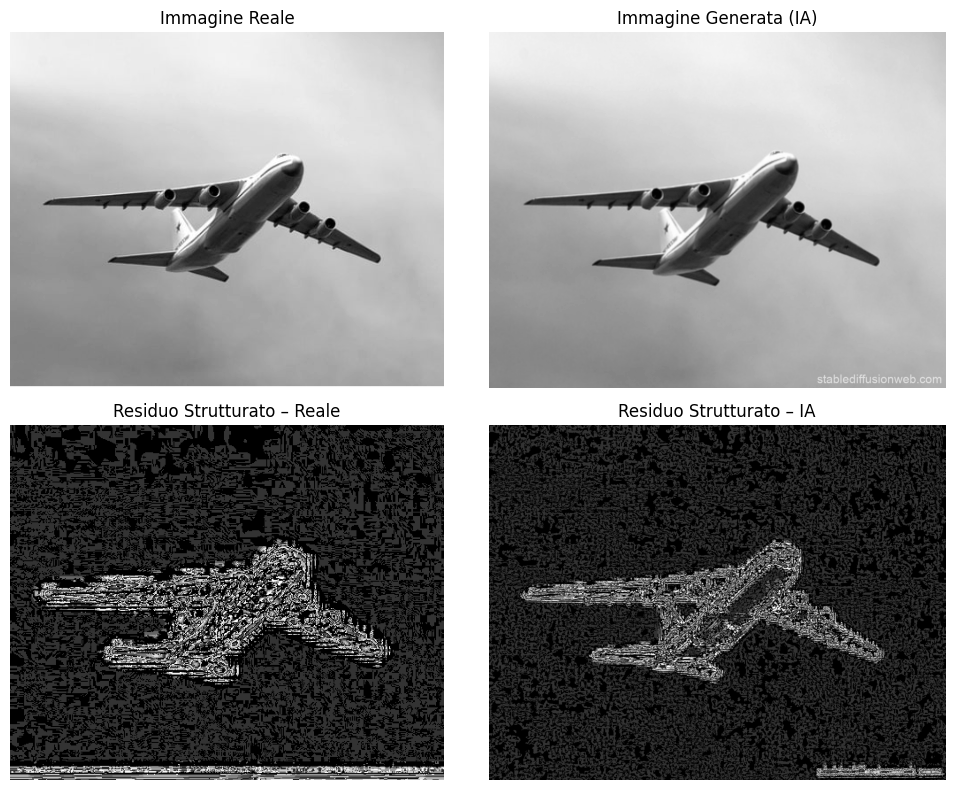

In [14]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pywt

# === CONFIGURAZIONE ===
# Inserisci i percorsi delle tue immagini (una reale e una generata)
real_path = "plane.jpg"
fake_path = "plane-f.jpg"

real = cv2.imread(real_path, cv2.IMREAD_GRAYSCALE)
fake = cv2.imread(fake_path, cv2.IMREAD_GRAYSCALE)

if real is None or fake is None:
    raise FileNotFoundError("Controlla i percorsi delle immagini.")

# --- 1. Funzione per ottenere residuo "strutturato"
def structured_residual(img, wavelet='db2', level=3, smooth_sigma=5):
    # Step 1: wavelet denoising
    coeffs = pywt.wavedec2(img, wavelet, level=level)
    cA, cD = coeffs[0], coeffs[1:]
    cD_H = [(np.zeros_like(h), np.zeros_like(v), np.zeros_like(d)) for (h, v, d) in cD]
    img_denoised = pywt.waverec2([cA] + cD_H, wavelet)
    img_denoised = img_denoised[:img.shape[0], :img.shape[1]]
    img_denoised = np.uint8(np.clip(img_denoised, 0, 255))

    # Step 2: residuo grezzo
    residual = cv2.absdiff(img, img_denoised)

    # Step 3: smoothing forte per enfatizzare strutture grandi
    smooth = cv2.GaussianBlur(residual, (0, 0), smooth_sigma)
    # differenza tra residuo e sua versione lisciata = residuo ad alta frequenza
    # ma vogliamo l'opposto → residuo "strutturato" = residuo - highfreq
    highfreq = cv2.absdiff(residual, smooth)
    structured = cv2.subtract(residual, highfreq)

    # Step 4: normalizza per visualizzazione
    structured = cv2.normalize(structured * 50, None, 0, 255, cv2.NORM_MINMAX)
    return np.uint8(structured)

# --- 2. Calcolo residui migliorati
real_residual = structured_residual(real)
fake_residual = structured_residual(fake)

# --- 3. Mostra risultati
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

axs[0, 0].imshow(real, cmap='gray')
axs[0, 0].set_title("Immagine Reale")
axs[0, 0].axis('off')

axs[0, 1].imshow(fake, cmap='gray')
axs[0, 1].set_title("Immagine Generata (IA)")
axs[0, 1].axis('off')

axs[1, 0].imshow(real_residual, cmap='gray')
axs[1, 0].set_title("Residuo Strutturato – Reale")
axs[1, 0].axis('off')

axs[1, 1].imshow(fake_residual, cmap='gray')
axs[1, 1].set_title("Residuo Strutturato – IA")
axs[1, 1].axis('off')

plt.tight_layout()
plt.show()